In [2]:
import json

# Load the labeled proposals (assumed to be in the JSON format as described)
proposal_file_path = '/zhome/28/8/203659/UNI/Computer Vision DL/Segmentation/02516_poster_3/labeled_proposals.json'  # Update with the actual path
with open(proposal_file_path, 'r') as f:
    proposals = json.load(f)


In [3]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
from PIL import Image
import os

class PotholeDatasetFromProposals(Dataset):
    def __init__(self, file_list, img_dir, proposals, transform=None):
        """
        Initialize the Pothole dataset using only the proposals JSON.
        
        Args:
            file_list (list): List of image filenames.
            img_dir (str): Directory where images are stored.
            proposals (dict): Proposed bounding boxes and labels for each image.
            transform (callable, optional): Optional transform to be applied on an image.
        """
        self.file_list = file_list
        self.img_dir = img_dir
        self.proposals = proposals
        self.transform = transform

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        # Get image filename
        img_name = self.file_list[idx]
        image_path = os.path.join(self.img_dir, img_name)
        
        # Load the image
        image = Image.open(image_path).convert("RGB")
        
        # Retrieve proposals for this image
        boxes = []
        labels = []
        for proposal in self.proposals.get(img_name, []):
            x, y, width, height = proposal["x"], proposal["y"], proposal["width"], proposal["height"]
            boxes.append([x, y, x + width, y + height])
            label = 0 if proposal['label'] == "background" else 1  # 0 for "background", 1 for "pothole"
            labels.append(label)
        
        # Convert to tensors
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        
        # Apply transformation to the image if specified
        if self.transform:
            image = self.transform(image)
        
        # Prepare target dictionary
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        
        return image, target


In [5]:
# Define image directory and list of image files based on proposal keys
img_dir = '/zhome/28/8/203659/UNI/Computer Vision DL/Segmentation/02516_poster_3/Potholes/annotated-images'
file_list = list(proposals.keys())  # Image files in the proposals

# Define transformations
transform = T.Compose([
    T.Resize((300, 300)),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Initialize dataset with only proposals
dataset = PotholeDatasetFromProposals(
    file_list=file_list,
    img_dir=img_dir,
    proposals=proposals,
    transform=transform
)

# Define DataLoader
dataloader = DataLoader(dataset, batch_size=8, shuffle=True, num_workers=4, collate_fn=lambda x: tuple(zip(*x)))

# Example loop to access batched data
for images, targets in dataloader:
    print("Batch of images:", images)
    print("Batch of targets:", targets)
    break  # Display only the first batch


Batch of images: (tensor([[[-0.0801, -0.0801, -0.0629,  ...,  0.0569,  0.3309,  0.2453],
         [-0.0458, -0.0458, -0.0458,  ..., -1.2274, -0.6281,  0.3481],
         [-0.0287, -0.0116, -0.0116,  ..., -1.6898, -1.5185, -0.9020],
         ...,
         [ 0.2967,  0.3994,  0.3481,  ...,  0.4851,  0.4851,  0.4337],
         [ 0.1597,  0.4337,  0.4337,  ...,  0.5707,  0.6734,  0.6392],
         [ 0.0912,  0.4337,  0.4679,  ...,  0.3652,  0.5022,  0.4508]],

        [[ 1.0805,  1.0805,  1.0980,  ...,  1.0980,  1.3081,  1.1856],
         [ 1.1155,  1.1155,  1.1155,  ..., -0.2850,  0.2577,  1.2031],
         [ 1.1331,  1.1506,  1.1506,  ..., -0.9328, -0.8452, -0.2500],
         ...,
         [ 0.2752,  0.3803,  0.3277,  ...,  0.4853,  0.4853,  0.4328],
         [ 0.1352,  0.4153,  0.4153,  ...,  0.5728,  0.6779,  0.6429],
         [ 0.0651,  0.4153,  0.4503,  ...,  0.3627,  0.5028,  0.4503]],

        [[ 2.3088,  2.3263,  2.3611,  ...,  2.0474,  2.1868,  2.0125],
         [ 2.3437,  2.3611,

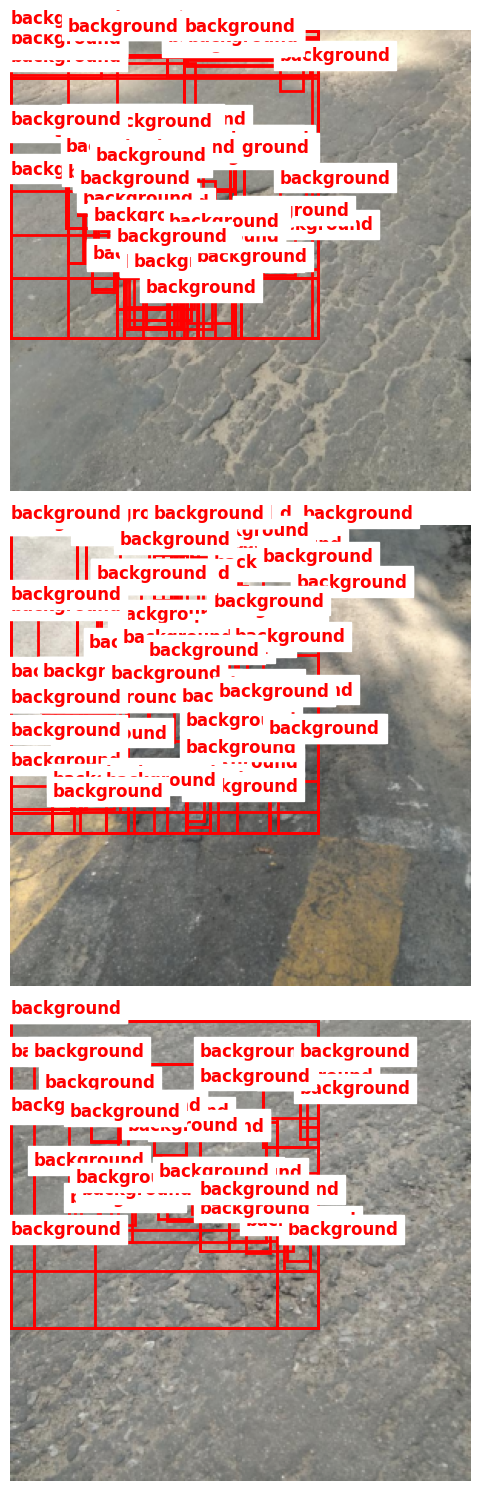

In [6]:
import matplotlib.pyplot as plt
import torch

def plot_sample_images(dataset, num_images=3):
    plt.figure(figsize=(15, 5 * num_images))
    for i in range(num_images):
        # Load image and target from dataset
        image, target = dataset[i]
        image_np = image.permute(1, 2, 0).numpy()  # Convert to numpy for plotting

        # Denormalize the image
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
        image_np = image_np * std + mean  # Undo normalization
        image_np = (image_np * 255).astype("uint8")  # Convert to uint8 format for display

        # Check image dimensions (after potential resizing)
        target_size = image_np.shape[:2]  # New size (height, width)
        
        # Plot the image
        plt.subplot(num_images, 1, i + 1)
        plt.imshow(image_np)
        plt.axis("off")

        # Plot bounding boxes without scaling if images are not resized
        for box, label in zip(target['boxes'], target['labels']):
            x_min, y_min, x_max, y_max = box
            color = (0, 1, 0) if label == 1 else (1, 0, 0)  # Green for 'pothole', red for 'background'
            plt.gca().add_patch(plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, 
                                              linewidth=2, edgecolor=color, facecolor='none'))
            plt.text(x_min, y_min - 5, 'pothole' if label == 1 else 'background', 
                     color=color, fontsize=12, weight='bold', backgroundcolor="white")
        
    plt.tight_layout()
    plt.show()

# Usage example (make sure the dataset object is initialized):
plot_sample_images(dataset, num_images=3)
